Ok so this here sheet is going to be a testbed for the full image subtraction routine for SN photometry. Note that it is being written to be applied to a single filter at a time, for simplicity!

Note that following the original script from GROWTH 2020, this script will remove the processed directories when you run it, so careful!

Also note that we assume the images have WCS, but might need to be rotated.

The source directory should contain just the source images. The data directory will be created by this code as the sources images + conifguration files, and the processed directory will be....the processed directory! This is awkward, but can't really figure out how to make it work otherwise...

First import relevant packages:

In [75]:
import os  #Call commands from outside Python

# Running external programs
import subprocess
import shutil

from astropy.coordinates import SkyCoord # For the catalog analysis during normalization

from astropy.io import fits #FITS files handling
from astropy.io import ascii  #Read/write ascii files

# Background subtraction
import photutils
#from photutils.detection import DAOStarFinder
from photutils.segmentation import detect_threshold, detect_sources
#from photutils import Background2D, MedianBackground # old version
from photutils.background import Background2D, MedianBackground 
from astropy.stats import sigma_clipped_stats, SigmaClip # statistics
from photutils.utils import circular_footprint

# Useful to smooth the images with a Gaussian kernel before the subtraction
from scipy.signal import convolve as scipy_convolve

# For rotation
import astroalign as aa

# Plot
import matplotlib.pyplot as plt

# Math help
import math

In [2]:
# Set directory structure
cwd = os.getcwd()

print("You start from the directory:", cwd)

source_dir = os.path.join(cwd, 'source') # All the stacked files should be in here
data_dir = os.path.join(cwd, 'data') # empty, but will get rewritten.
if os.path.isdir(data_dir): # checks and removes if it exists. 
    shutil.rmtree(data_dir)
os.mkdir(data_dir)
proc_dir = os.path.join(cwd, 'processed') # all processes fits files.
out_dir = os.path.join(proc_dir, 'out') # output files are here
if os.path.isdir(proc_dir): # checks and removes if it exists. 
    shutil.rmtree(proc_dir)
os.mkdir(proc_dir)
config_dir = os.path.join(cwd, 'config') # various configuration files, should exist!
if os.path.exists(config_dir)==False:
    print("Error, config directory does not exist!")
    raise

for f in os.listdir(source_dir): # copy sources into data directory.
    shutil.copy2(os.path.join(source_dir, f), os.path.join(data_dir,f))
for f in os.listdir(config_dir): # copy configuration into data directory.
    shutil.copy2(os.path.join(config_dir, f), data_dir)
for f in os.listdir(data_dir): # copy data into processed and change to it.
    shutil.copy2(os.path.join(data_dir, f), proc_dir)

os.chdir(proc_dir)
print("You are working in the image_subtraction/processed/ directory: ")
print("Full path:", proc_dir)

You start from the directory: /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction
You are working in the image_subtraction/processed/ directory: 
Full path: /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed


## Image Rotation

First we need to rotate the reference images to match the science images. This task will rotate all of the images to the first one, which is likely the first science image. This borks up the WCS, so we should try to put that back!

In [3]:
image_array=[]
for f in os.listdir(source_dir): # create list of raw images
    image_array.append(f)
    
image_array

['SUM_Aligned_20230308_I.fits',
 'SUM_Aligned_20230309_I.fits',
 'SUM_Aligned_20230310_I.fits',
 'SUM_Aligned_20230311_I.fits',
 'SUM_Aligned_20230312_I.fits',
 'SUM_Aligned_20230313_I.fits',
 'SUM_Aligned_20240116_I.fits',
 'SUM_Aligned_20240119_I.fits']

In [4]:
# Removing the separate rotated directory!

# create rotated directory
#rot_dir = os.path.join(proc_dir, 'rotated')
#if os.path.isdir(rot_dir): # checks and removes if it exists. 
#    shutil.rmtree(rot_dir)
#os.mkdir(rot_dir)

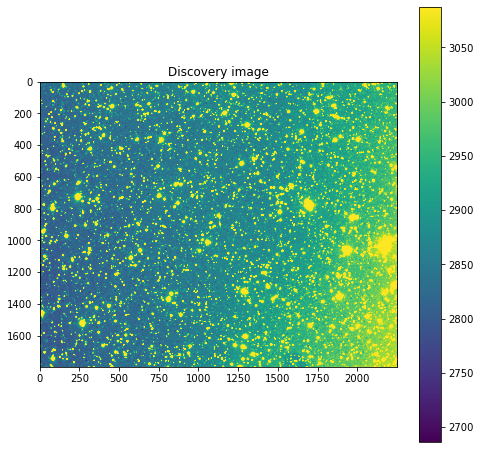

In [5]:
# Discovery image to rotate into
dis_image_name = os.path.join(data_dir, image_array[0])
dis_image = fits.open(dis_image_name)

#Plot that?
mean, median, std = sigma_clipped_stats(dis_image[0].data)
plt.figure(figsize=(8,8))

# Set the scale of the image based on its statistics
# p/m two sigma.
plt.imshow(dis_image[0].data, vmin=median-2*std, vmax=median+2*std)
plt.colorbar()
plt.title('Discovery image')
plt.show()

This line (needs to be done with all) are to deal with some kind of small/large emden order, see this: 

https://github.com/quatrope/astroalign/issues/70

In [6]:
dis_data = dis_image[0].data
dis = dis_data.byteswap().newbyteorder()

In [7]:
rot_name_array=[]
# loop through the other images
for i in range(len(image_array)-1):
    src_image_name = os.path.join(data_dir, image_array[i+1])
    src_image = fits.open(src_image_name)
    src_data = src_image[0].data
    src = src_data.byteswap().newbyteorder()
    #rotates src into dis
    img_aligned, footprint = aa.register(src, dis, detection_sigma=3.0) #detection criteria pretty random
    # create new file
    hdu = fits.PrimaryHDU(img_aligned)
    rot_name=image_array[i+1].split(".")[0]+"_Rotated.fits" # Do this in a smarter way later!
    rot_name_array.append(rot_name)
    hdu.writeto(proc_dir+"/"+rot_name, overwrite = True)

In [8]:
rot_name_array

['SUM_Aligned_20230309_I_Rotated.fits',
 'SUM_Aligned_20230310_I_Rotated.fits',
 'SUM_Aligned_20230311_I_Rotated.fits',
 'SUM_Aligned_20230312_I_Rotated.fits',
 'SUM_Aligned_20230313_I_Rotated.fits',
 'SUM_Aligned_20240116_I_Rotated.fits',
 'SUM_Aligned_20240119_I_Rotated.fits']

That should do it - maybe should check via AstroImagej, but worked in testing.

## Subtraction Routine

This part comes from the GROWTH 2020 school, with my own modifications and dealing with some recent changes to the code. We'll start with a dependency check:

(for now skipping all reference to ds9, since that doesn't actually seem that useful atm.)

In [9]:
def test_dependency(dep, alternate_name=None):
    """
    Test external dependency by trying to run it as a subprocess
    """
    try:
        subprocess.check_output(dep, stderr=subprocess.PIPE, shell=True)
        print("%s is installed properly as %s. OK" % (dep, dep))
        return 1
    except subprocess.CalledProcessError:
        try:
            subprocess.check_output(alternate_name, stderr=subprocess.PIPE, shell=True)
            print("%s is installed properly as %s. OK" % (dep, alternate_name))
            return 1
        except subprocess.CalledProcessError:
            print("===%s/%s IS NOT YET INSTALLED PROPERLY===" % (dep, alternate_name))
            return 0

#dependencies = [('sextractor', 'sex'), ('SWarp', 'swarp'), ('psfex', 'PSFEx'), ('ds9', 'DS9')]
#dependencies = [('sextractor', 'source-extractor'), ('SWarp', 'swarp'), ('psfex', 'PSFEx'), ('ds9', 'DS9')]
dependencies = [('sextractor', 'source-extractor'), ('SWarp', 'swarp'), ('psfex', 'PSFEx')]
i = 0
for dep_name1, dep_name2 in dependencies:
    i += test_dependency(dep_name1, dep_name2)
print("%i out of %i external dependencies installed properly.\n" % (i, len(dependencies)))
if i != len(dependencies):
    print("Please correctly install these programs before continuing by following the instructions in README.md.")
else:
    print("You are ready to continue.")   

sextractor is installed properly as source-extractor. OK
SWarp is installed properly as swarp. OK
psfex is installed properly as psfex. OK
3 out of 3 external dependencies installed properly.

You are ready to continue.


In [10]:
# move to rotated directory we created above
#os.chdir(rot_dir)
#print("Full path:", rot_dir)

## Align the images

Use the AstrOmatic Swarp package to align the images.  Swarp relies on the astrometric information of the image (in other words, on the sky coordinates), therefore both the science and reference images must be astrometrically calibrated (for example, using the AstrOmatic SCAMP package).  In this module we assume that the input images are already calibrated. (the images from iTelescope are already calibrated, for example)

We should be trying to pass the entire list to swarp at once, methinks.

In [11]:
#rot_image_array=[]
swarp_filelist_name=config_dir+"/"+'swarp_filelist.txt'
swarp_filelist = open(swarp_filelist_name, 'w')
for f in rot_name_array: 
    #rot_image_array.append(f)
    print(f)
    swarp_filelist.write(str(f) + "\n")
swarp_filelist.close()

SUM_Aligned_20230309_I_Rotated.fits
SUM_Aligned_20230310_I_Rotated.fits
SUM_Aligned_20230311_I_Rotated.fits
SUM_Aligned_20230312_I_Rotated.fits
SUM_Aligned_20230313_I_Rotated.fits
SUM_Aligned_20240116_I_Rotated.fits
SUM_Aligned_20240119_I_Rotated.fits


Note in this next command the size of the box is basically dummy for right now. Should just be square at least...

In [12]:
# Swarp command
# had to change capitalization of SWarp!
try:
    #command = "swarp %s %s -c %s -SUBTRACT_BACK N -RESAMPLE Y -RESAMPLE_DIR . -COMBINE N -IMAGE_SIZE 1800,900" % (sci_image_name, ref_image_name, os.path.join(config_dir, 'config.swarp'))
    command = "swarp @%s -c %s -SUBTRACT_BACK N -RESAMPLE Y -RESAMPLE_DIR . -COMBINE N -IMAGE_SIZE 1800,900" % (swarp_filelist_name, os.path.join(config_dir, 'config.swarp'))
    print('Executing command: %s' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run SWarp with exit error %s'%err)

# Gotta fix the names of the aligned images
swarp_filelist = open(swarp_filelist_name, 'r')
align_image_array=[]
for line in swarp_filelist:
    #print(line)
    align_image_array.append(line.strip().replace(".fits", ".resamp.fits").replace('data','processed'))
#sci_image_aligned_name = sci_image_name.replace(".fits", ".resamp.fits").replace('data','processed')
#ref_image_aligned_name = ref_image_name.replace(".fits", ".resamp.fits").replace('data','processed')
swarp_filelist.close()

Executing command: swarp @/media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/config/swarp_filelist.txt -c /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/config/config.swarp -SUBTRACT_BACK N -RESAMPLE Y -RESAMPLE_DIR . -COMBINE N -IMAGE_SIZE 1800,900


> 
----- SWarp 2.41.5 started on 2024-02-28 at 15:03:06 with 12 threads

> Examining input data ...
> Looking for SUM_Aligned_20230309_I_Rotated.fits ...
> Looking for SUM_Aligned_20230310_I_Rotated.fits ...
> Looking for SUM_Aligned_20230311_I_Rotated.fits ...
> Looking for SUM_Aligned_20230312_I_Rotated.fits ...
> Looking for SUM_Aligned_20230313_I_Rotated.fits ...
> Looking for SUM_Aligned_20240116_I_Rotated.fits ...
> Looking for SUM_Aligned_20240119_I_Rotated.fits ...
> Creating NEW output image ...
> Creating NEW weight-map ...
> 
------- Output File swarpout.fits:
    "no ident"  WEIGHTED  no ext. header  1800x900  32 bits (floats)
    Center: 1.12e+03,899   1.8e+03x900  Scale: 1x1 /pixel
    Gain: 0 e-/ADU   Flux scaling (astrom/photom): 1 X / 1 X

> Loading input data ...
> 
-------------- File SUM_Aligned_20230309_I_Rotated.fits:
    "no ident"  unweighted  no ext. header  2250x1800  32 bits (floats)
    Center: 1.12e+03,900   2.25e+03x1.8e+03  Scale: 1x1 /pixel
    Gain: 4 e

Success!


> Resampling line:    666 / 900    
> 
-------------- File SUM_Aligned_20240116_I_Rotated.fits:
    "no ident"  unweighted  no ext. header  2250x1800  32 bits (floats)
    Center: 1.12e+03,900   2.25e+03x1.8e+03  Scale: 1x1 /pixel
    Gain: 4 e-/ADU   Flux scaling (astrom/photom): 1 X / 1 X
> Setting up background maps ...
> Setting up background map at line:    512 / 1800   
> Setting up background map at line:   1024 / 1800   
> Setting up background map at line:   1536 / 1800   
> Filtering background map(s) ...
> Computing backgound d-map ...
> Computing backgound-noise d-map ...
    Background: 2046.207   RMS: 70.5827

> Reading SUM_Aligned_20240116_I_Rotated.fits
> Resampling SUM_Aligned_20240116_I_Rotated.fits ...
> Resampling line:      0 / 900    
> Resampling line:    333 / 900    
> Resampling line:    666 / 900    
> 
-------------- File SUM_Aligned_20240119_I_Rotated.fits:
    "no ident"  unweighted  no ext. header  2250x1800  32 bits (floats)
    Center: 1.12e+03,900   2.

In [13]:
align_image_array

['SUM_Aligned_20230309_I_Rotated.resamp.fits',
 'SUM_Aligned_20230310_I_Rotated.resamp.fits',
 'SUM_Aligned_20230311_I_Rotated.resamp.fits',
 'SUM_Aligned_20230312_I_Rotated.resamp.fits',
 'SUM_Aligned_20230313_I_Rotated.resamp.fits',
 'SUM_Aligned_20240116_I_Rotated.resamp.fits',
 'SUM_Aligned_20240119_I_Rotated.resamp.fits']

And AstroImageJ verifies this basically looks right - but notice again the cropping might not make that such sense.

# Background Subtraction
- Mask sources in images
- Use 3 sigma clipping to filter data and accurately measure the backgorund
- Then split image into 300x300 pixel boxes and apply 2x2 median filter

That was the original. We are going to (for the first image)

1) look at the scalar background
2) look at the 2D background with no mask
3) look at the 2D background a mask

And then assume (3) is best and go ahead with subtracting them all!

In [14]:
# Eventually do this for each image in the array.
image = fits.open(align_image_array[0])
hdr = image[0].header #save fits header

#estimate scalar background with sourcemask
sigma_clip = SigmaClip(sigma=3.0, maxiters=10)
threshold = detect_threshold(image[0].data, nsigma=2.0, sigma_clip=sigma_clip)
segment_img = detect_sources(image[0].data, threshold, npixels=10)
footprint = circular_footprint(radius=10) #watch this footprint value, should be inspected!
mask = segment_img.make_source_mask(footprint=footprint)
mean, median, std = sigma_clipped_stats(image[0].data, sigma=3.0, mask=mask)
print((mean, median, std))  

(1847.5392, 1845.7213, 56.494694)


Somehow we should evaluate that...

ok but I think for real we just SKIP those scalar, and go right for the 2D background estimator (50x50 box, 3x3 median filter):

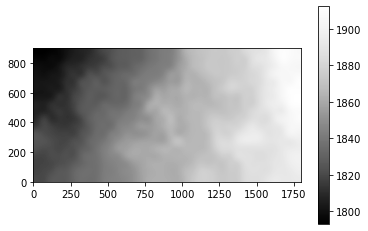

In [15]:
bkg_estimator = MedianBackground()
sigma_clip = SigmaClip(sigma=3.0)
bkg = Background2D(image[0].data, (50, 50), filter_size=(3, 3),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)
plt.imshow(bkg.background, origin='lower', cmap='Greys_r',interpolation='nearest')
plt.colorbar()

I suppose there is some effect of the background stars here - since we are not doing any masking. Let's try the same mask from above, and see if it gets any better?

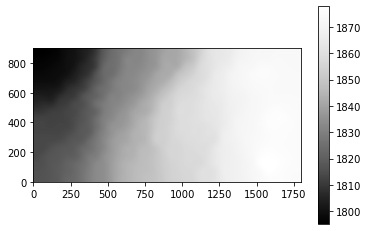

In [16]:
bkg = Background2D(image[0].data, (50, 50), filter_size=(3, 3),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator,mask=mask)
plt.imshow(bkg.background, origin='lower', cmap='Greys_r',interpolation='nearest')
plt.colorbar()

yyyeaahh I guess that's better, the background should probably be NOT bumpy at all. So use this and background subtract everything.

(Background goes negative here, I had real problems in AIJ with that....)

In [17]:
# Do this for each image in the array.
bkg_subtract_array=[]
for i in range(len(align_image_array)):
    image = fits.open(align_image_array[i])
    hdr = image[0].header #save fits header
    # measure and subtract the background
    bkg = Background2D(image[0].data, (50, 50), filter_size=(3, 3),sigma_clip=sigma_clip, bkg_estimator=bkg_estimator,mask=mask)
    bkg_subtract_name=align_image_array[i].replace(".resamp.fits", "_bkgsub.fits")
    bkg_subtract_array.append(bkg_subtract_name)
    image[0].data = image[0].data - bkg.background
    hdu_image_sub = fits.PrimaryHDU(image[0].data)
    hdu_image_sub.writeto(bkg_subtract_name,overwrite=True)

These images look right, but I did get an error that these images are now double precision, whereas AIJ expects single precision. Fine for now?


In [18]:
bkg_subtract_array

['SUM_Aligned_20230309_I_Rotated_bkgsub.fits',
 'SUM_Aligned_20230310_I_Rotated_bkgsub.fits',
 'SUM_Aligned_20230311_I_Rotated_bkgsub.fits',
 'SUM_Aligned_20230312_I_Rotated_bkgsub.fits',
 'SUM_Aligned_20230313_I_Rotated_bkgsub.fits',
 'SUM_Aligned_20240116_I_Rotated_bkgsub.fits',
 'SUM_Aligned_20240119_I_Rotated_bkgsub.fits']

## PSF matching

The atmosphere heavily affects the PSF of the images by determining the "seeing" conditions. The seeing for ground-based optical telescopes is usually measured as the FWHM of the imaging PSF.  Properties of the atmosphere can change very rapidly, so it is rare that science and reference images are characterized by the same seeing. Therefore their PSFs are usually different, which is a problem for image subtraction. 


### Generate the kernel for the convolution

The PSF of the science and reference images can be matched in several different ways.  Here we start by performing a first source extraction on the reference image (which we assume to be the last in the list).  We can use the catalogs of sources that we obtain for two main purposes: <br />
1. Measure the PSF of the science frame, using PSFex or photutils
2. Obtain instruments magnitudes that will be the basis for the zero-point calibration (see Photometry module).  


In [20]:
bkg_subtract_array[len(bkg_subtract_array)-1]

'SUM_Aligned_20240119_I_Rotated_bkgsub.fits'

In [21]:
# use REFERENCE image to extract sources.
# overwriting the catalog, but I guess that doesn't matter much.

ref_image_bkgsub_name = os.path.join(proc_dir, bkg_subtract_array[len(bkg_subtract_array)-1])

try:
    #command = "sextractor %s -c %s -CATALOG_NAME %s -MAG_ZEROPOINT 25.0" % (sci_image_aligned_name, os.path.join(data_dir, 'prepsfex.sex'), os.path.join(proc_dir, 'prepsfex.cat'))
    #command = "source-extractor %s -c %s -CATALOG_NAME %s -MAG_ZEROPOINT 25.0" % (sci_image_aligned_name, os.path.join(data_dir, 'prepsfex.sex'), os.path.join(proc_dir, 'prepsfex.cat'))
    command = "source-extractor %s -c %s -CATALOG_NAME %s -MAG_ZEROPOINT 25.0" % (ref_image_bkgsub_name, os.path.join(data_dir,'prepsfex.sex'), os.path.join(proc_dir, 'prepsfex.cat'))
    print('Executing command: %s\n' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run SExtractor with exit error %s'%err)

Executing command: source-extractor /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/SUM_Aligned_20240119_I_Rotated_bkgsub.fits -c /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/data/prepsfex.sex -CATALOG_NAME /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/prepsfex.cat -MAG_ZEROPOINT 25.0

Success!


Now we use another software part of the AstrOmatic suite, PSFex, to measure the PSF of the science image(s). PSFex estimates the PSF based on the information present in the catalog generated with SExtractor.  Then, let's plot the PSF model obtained with PSFex

Executing command: psfex prepsfex.cat -c psfex_conf.psfex




> WARNING: NTHREADS != 1 ignored: this build of PSFEx is single-threaded



Success!
/media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/out/proto_prepsfex.fits



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.



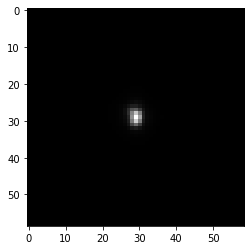

In [23]:
# Run PSFex to compute PSF, read and display the final model; needs to output to "out" dir.
if not os.path.isdir('out'): os.mkdir('out')

try:
    command = "psfex prepsfex.cat -c psfex_conf.psfex"
    #command = "psfex %s -c %s" % (source_extract_cat_name,psfex_config_name)
    print('Executing command: %s\n' % command)
    rval = subprocess.run(command.split(), check=True)
    print('Success!')
except subprocess.CalledProcessError as err:
    print('Could not run psfex with exit error %s'%err)

psf_ref_image_name = os.path.join(out_dir,'proto_prepsfex.fits') # temporary name?
print(psf_ref_image_name)
psf_ref_image = fits.open(psf_ref_image_name)

plt.imshow(psf_ref_image[0].data[0], cmap='gray')

mostly round ball...as expected...

### Convolve the reference image with the PSF of each science image

Now that the kernel is generated, let's convolve the reference image with the PSF of each science frame.

/media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/SUM_Aligned_20230309_I_Rotated_bkgsub_conv.fits


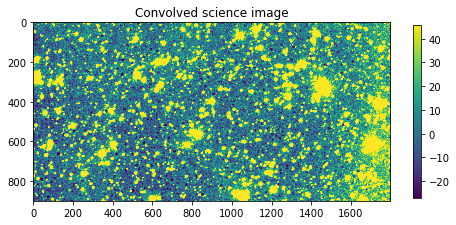

/media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/SUM_Aligned_20230310_I_Rotated_bkgsub_conv.fits


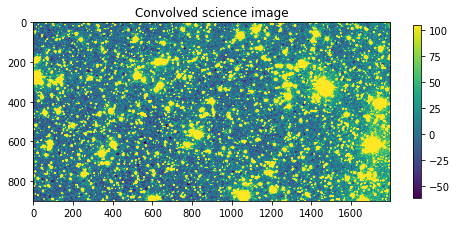

/media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/SUM_Aligned_20230311_I_Rotated_bkgsub_conv.fits


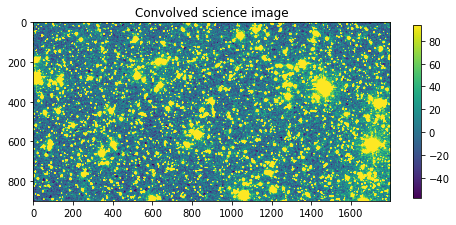

/media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/SUM_Aligned_20230312_I_Rotated_bkgsub_conv.fits


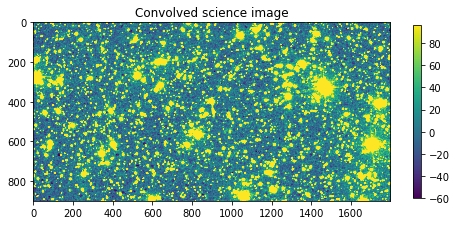

/media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/SUM_Aligned_20230313_I_Rotated_bkgsub_conv.fits


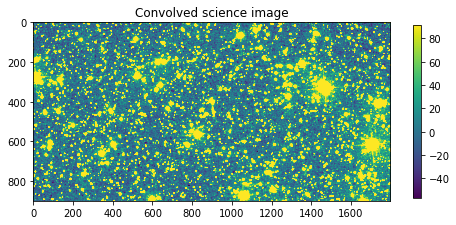

/media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/SUM_Aligned_20240116_I_Rotated_bkgsub_conv.fits


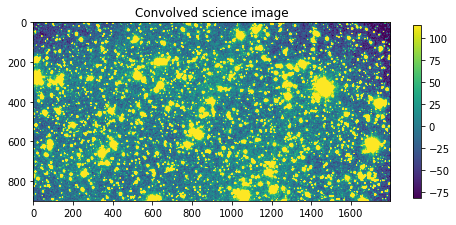

In [66]:
# Convolve the kernel of the reference image with the PSF of the science frame
kernel_ref = psf_ref_image[0].data[0]

# for plotting
#fig, axes = plt.subplots(3, math.ceil(len(bkg_subtract_array)/3.))
#plt.figure(figsize=(4,4))

sci_conv_array=[]
for i in range(len(bkg_subtract_array)-1): # don't need to do the last one, that's reference
    sci_bkg_subtract = fits.open(bkg_subtract_array[i])
    sci_conv = scipy_convolve(sci_bkg_subtract[0].data, kernel_ref, mode='same', method='fft') # convolve step
    hdu_sci_conv = fits.PrimaryHDU(sci_conv,sci_bkg_subtract[0].header) # really should be adding header keys!
    sci_conv_array.append(bkg_subtract_array[i].replace(".fits","_conv.fits"))
    sci_conv_name=os.path.join(proc_dir,sci_conv_array[i])
    
    # Images not being created!
    print(sci_conv_name)
    hdu_sci_conv.writeto(sci_conv_name,overwrite=True)

    #Plot up the convolved reference image
    mean, median, std = sigma_clipped_stats(hdu_sci_conv.data)
    plt.figure(figsize=(8,8))

    # set the scale of the image based on its statistics
    plt.imshow(sci_bkg_subtract[0].data, vmin=median-2*std, vmax=median+2*std)
    plt.colorbar(shrink = 0.4)
    plt.title('Convolved science image')
    plt.show()

Kinda hard to tell they are changing, but I think they are!

Next step is actually to create a refernce image for each science image, which is the reference convolved with the science. Then each pair should have the same PSF.

In [67]:
sci_conv_array

['SUM_Aligned_20230309_I_Rotated_bkgsub_conv.fits',
 'SUM_Aligned_20230310_I_Rotated_bkgsub_conv.fits',
 'SUM_Aligned_20230311_I_Rotated_bkgsub_conv.fits',
 'SUM_Aligned_20230312_I_Rotated_bkgsub_conv.fits',
 'SUM_Aligned_20230313_I_Rotated_bkgsub_conv.fits',
 'SUM_Aligned_20240116_I_Rotated_bkgsub_conv.fits']

### Convolve the science image with the PSF of the reference image


Same as above, but this time we generate a kernel with the properties of the PSF of the discovery image.  Then, we convolve the reference image with this kernel.

I think what is happening here is the PSF data is stored in prepsfex.cat, as an output catalog from source-extractor, so we need to re-run the source extractor to get the PSF of the image in question.

Kernel from *each* science image

Executing command: source-extractor /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/SUM_Aligned_20230309_I_Rotated_bkgsub.fits -c /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/data/prepsfex.sex -CATALOG_NAME /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/prepsfex.cat -MAG_ZEROPOINT 25.0

Success!
Executing command: psfex prepsfex.cat -c psfex_conf.psfex




> WARNING: NTHREADS != 1 ignored: this build of PSFEx is single-threaded



Success!
/media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/out/proto_prepsfex.fits



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.



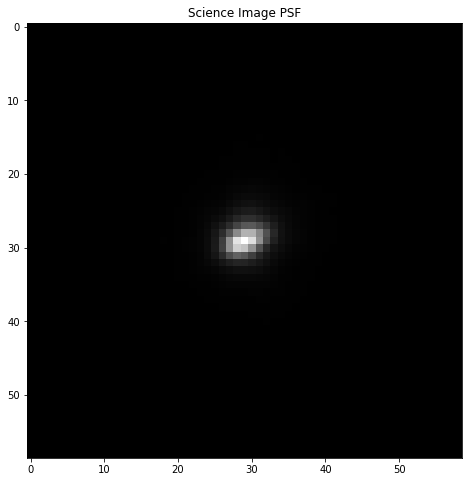

/media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/SUM_Aligned_20230309_I_Rotated_bkgsub_refconv.fits


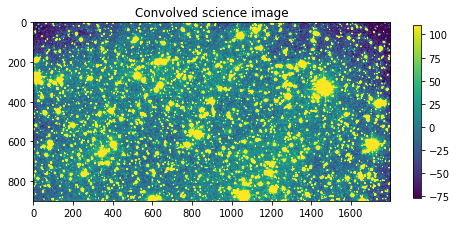

Executing command: source-extractor /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/SUM_Aligned_20230310_I_Rotated_bkgsub.fits -c /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/data/prepsfex.sex -CATALOG_NAME /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/prepsfex.cat -MAG_ZEROPOINT 25.0

Success!
Executing command: psfex prepsfex.cat -c psfex_conf.psfex




> WARNING: NTHREADS != 1 ignored: this build of PSFEx is single-threaded



Success!
/media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/out/proto_prepsfex.fits



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.



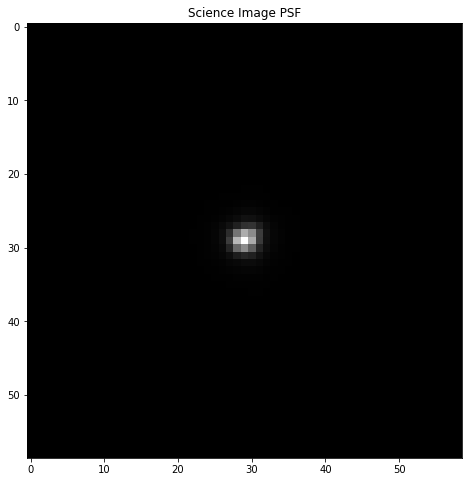

/media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/SUM_Aligned_20230310_I_Rotated_bkgsub_refconv.fits


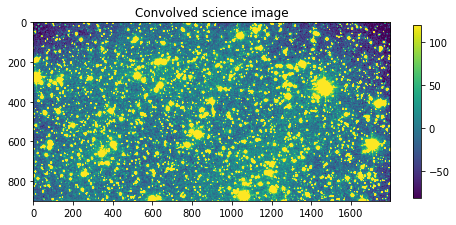

Executing command: source-extractor /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/SUM_Aligned_20230311_I_Rotated_bkgsub.fits -c /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/data/prepsfex.sex -CATALOG_NAME /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/prepsfex.cat -MAG_ZEROPOINT 25.0

Success!
Executing command: psfex prepsfex.cat -c psfex_conf.psfex




> WARNING: NTHREADS != 1 ignored: this build of PSFEx is single-threaded



Success!
/media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/out/proto_prepsfex.fits



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.



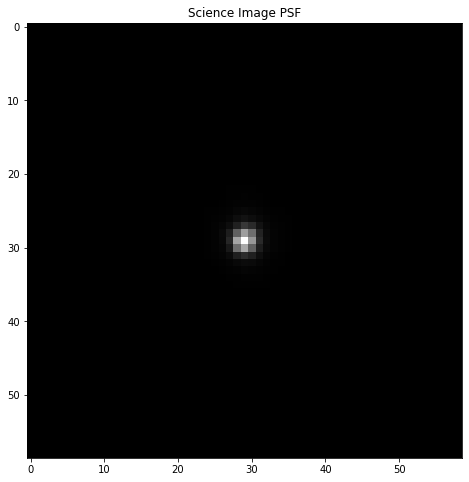

/media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/SUM_Aligned_20230311_I_Rotated_bkgsub_refconv.fits


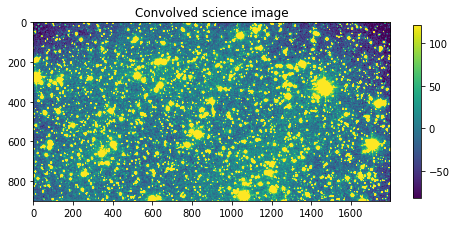

Executing command: source-extractor /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/SUM_Aligned_20230312_I_Rotated_bkgsub.fits -c /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/data/prepsfex.sex -CATALOG_NAME /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/prepsfex.cat -MAG_ZEROPOINT 25.0

Success!
Executing command: psfex prepsfex.cat -c psfex_conf.psfex




> WARNING: NTHREADS != 1 ignored: this build of PSFEx is single-threaded



Success!
/media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/out/proto_prepsfex.fits



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.



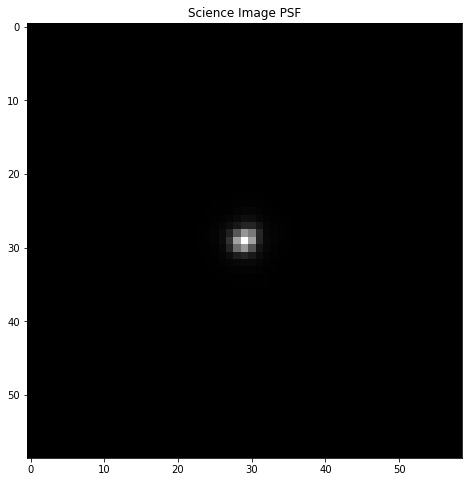

/media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/SUM_Aligned_20230312_I_Rotated_bkgsub_refconv.fits


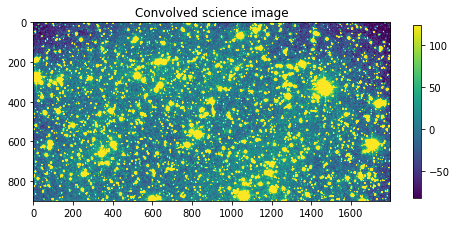

Executing command: source-extractor /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/SUM_Aligned_20230313_I_Rotated_bkgsub.fits -c /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/data/prepsfex.sex -CATALOG_NAME /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/prepsfex.cat -MAG_ZEROPOINT 25.0

Success!
Executing command: psfex prepsfex.cat -c psfex_conf.psfex




> WARNING: NTHREADS != 1 ignored: this build of PSFEx is single-threaded



Success!
/media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/out/proto_prepsfex.fits



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.



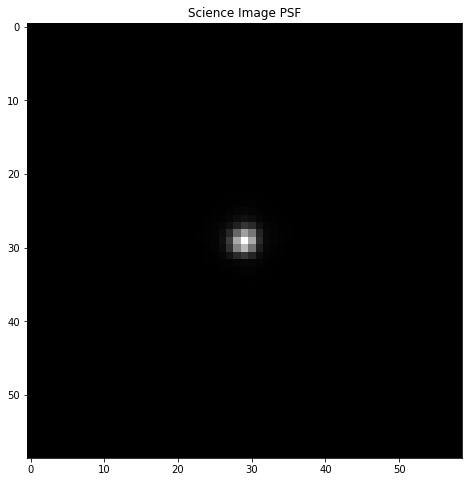

/media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/SUM_Aligned_20230313_I_Rotated_bkgsub_refconv.fits


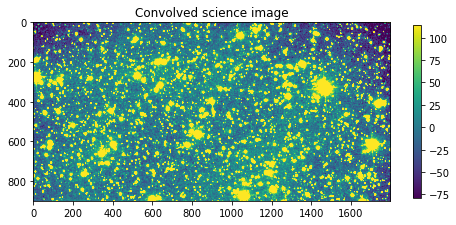

Executing command: source-extractor /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/SUM_Aligned_20240116_I_Rotated_bkgsub.fits -c /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/data/prepsfex.sex -CATALOG_NAME /media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/prepsfex.cat -MAG_ZEROPOINT 25.0

Success!
Executing command: psfex prepsfex.cat -c psfex_conf.psfex




> WARNING: NTHREADS != 1 ignored: this build of PSFEx is single-threaded



Success!
/media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/out/proto_prepsfex.fits



*** PLPLOT WARNING ***
Driver does not support hardware solid fills, switching to software fill.



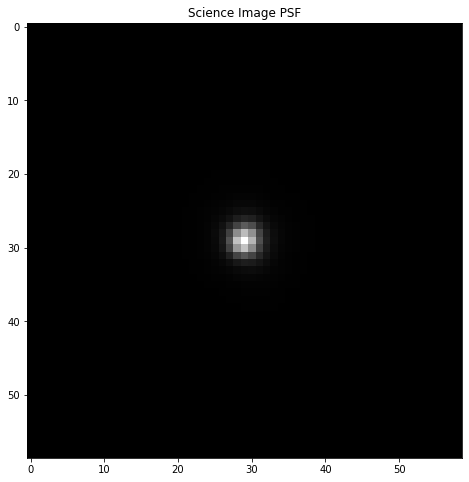

/media/cduston/MCARG/AnalyzedSources/SN2023ctn/Stacked/image_subtraction/processed/SUM_Aligned_20240116_I_Rotated_bkgsub_refconv.fits


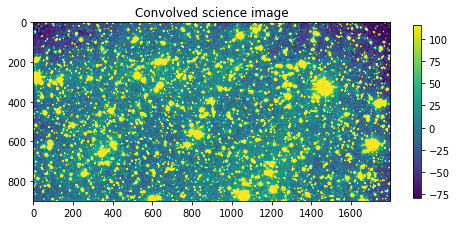

In [68]:
ref_conv_array=[]
for i in range(len(bkg_subtract_array)-1): # don't need to do the last one, that's the reference
    sci_image_bkgsub_name = os.path.join(proc_dir, bkg_subtract_array[i])

    try:
        command = "source-extractor %s -c %s -CATALOG_NAME %s -MAG_ZEROPOINT 25.0" % (sci_image_bkgsub_name, os.path.join(data_dir,'prepsfex.sex'), os.path.join(proc_dir, 'prepsfex.cat'))
        print('Executing command: %s\n' % command)
        rval = subprocess.run(command.split(), check=True)
        print('Success!')
    except subprocess.CalledProcessError as err:
        print('Could not run SExtractor with exit error %s'%err)
     
    # Run PSFex to compute PSF, read and display the final model; needs to output to "out" dir.
    if not os.path.isdir('out'): os.mkdir('out') # should be made already

    try:
        command = "psfex prepsfex.cat -c psfex_conf.psfex"
        print('Executing command: %s\n' % command)
        rval = subprocess.run(command.split(), check=True)
        print('Success!')
    except subprocess.CalledProcessError as err:
        print('Could not run psfex with exit error %s'%err)

    psf_sci_image_name = os.path.join(out_dir,'proto_prepsfex.fits') # DEFAULT name
    #psf_sci_image_name = os.path.join(out_dir,bkg_subtract_array[i].replace('.fits','_protoPSF.fits')) # rewriting each time!
    print(psf_sci_image_name)
    psf_sci_image = fits.open(psf_sci_image_name)
    # only the last image shows...
    plt.figure(figsize=(8,8))
    plt.imshow(psf_sci_image[0].data[0], cmap='gray')       
    plt.title('Science Image PSF')
    plt.show()   
        
    # Convolve the reference image with the PSF of each science frame
    # Grab the kernel!
    kernel_sci = psf_sci_image[0].data[0]
    
    # careful naming scheme needed!
    ref_bkg_subtract = fits.open(bkg_subtract_array[len(bkg_subtract_array)-1]) # REFERENCE IS LAST IMAGE!
    ref_conv = scipy_convolve(ref_bkg_subtract[0].data, kernel_sci, mode='same', method='fft') # convolve step
    hdu_ref_conv = fits.PrimaryHDU(ref_conv,ref_bkg_subtract[0].header) # really should be adding header keys!
    
    ref_conv_array.append(bkg_subtract_array[i].replace(".fits","_refconv.fits"))
    ref_conv_name=os.path.join(proc_dir,ref_conv_array[i])
    
    #ref_conv_name=os.path.join(proc_dir,bkg_subtract_array[i].replace(".fits","_refconv.fits"))
    
    
    # Images not being created!
    print(ref_conv_name)
    hdu_ref_conv.writeto(ref_conv_name,overwrite=True)

    #Plot up the convolved reference image
    mean, median, std = sigma_clipped_stats(hdu_ref_conv.data)
    plt.figure(figsize=(8,8))

    # set the scale of the image based on its statistics
    plt.imshow(ref_bkg_subtract[0].data, vmin=median-2*std, vmax=median+2*std)
    plt.colorbar(shrink = 0.4)
    plt.title('Convolved science image')
    plt.show()
    

In [69]:
ref_conv_array

['SUM_Aligned_20230309_I_Rotated_bkgsub_refconv.fits',
 'SUM_Aligned_20230310_I_Rotated_bkgsub_refconv.fits',
 'SUM_Aligned_20230311_I_Rotated_bkgsub_refconv.fits',
 'SUM_Aligned_20230312_I_Rotated_bkgsub_refconv.fits',
 'SUM_Aligned_20230313_I_Rotated_bkgsub_refconv.fits',
 'SUM_Aligned_20240116_I_Rotated_bkgsub_refconv.fits']

(I think this step should go inside the normalization loop somewhere, so skipping to that...)

### Improving the alignment
Now that the science image is convolved with (an approximation of) the PSF of the reference image, 
and the reference image is convolved with the PSF of the science image, we can perform the image subtraction.

- Before the subtraction we use an fft method (chi_2_shift) to fine-tune the image alignment of the reference and science image. We'll do this in pairs, reference aligning with science. When we go do photometry with AIJ, this fine tuning doesn't matter so much.

## Normalization of the images

The science and reference images are usually obtained with different exposure times.  In addition, the reference image can be the stack of several images to increase the depth.  Finally, different CCDs of the same camera (or even different regions of the same CCD when multiple amplifiers are present) may have slightly different gain. <br >

The background subtraction should have removed the non-linear offsets between science and reference images.  We can therefore normalize the two images by computing the ratio of bright star fluxes in the two images. Once again, we use SExtractor to extract the flux and other quantities.

We should be able to do this pairwise as well, as the offsets between different science images should be taken care of with our differential photometry. So we'll maybe normalize the reference to the science?

In [77]:
for i in range(len(bkg_subtract_array)-1): # don't need to do the last one, that's the reference
    # Run SExtractor on the science image
    sextractor_command = "source-extractor %s -c prepsfex.sex -CATALOG_NAME sci_match.cat -MAG_ZEROPOINT 25.0 -CATALOG_TYPE=ASCII_HEAD" % (sci_conv_array[i])

    try:
        command = sextractor_command
        print('Executing command: %s\n' % command)
        rval = subprocess.run(command.split(), check=True)
        print('Success!')
    except subprocess.CalledProcessError as err:
        print('Could not run SExtractor with exit error %s'%err)

    cat_sci = ascii.read('sci_match.cat') # dummy, should be able to rewrite constantly
    
    # Run SExtractor on the reference image
    sextractor_command = "source-extractor %s -c prepsfex.sex -CATALOG_NAME ref_match.cat -MAG_ZEROPOINT 25.0 -CATALOG_TYPE=ASCII_HEAD" % (ref_conv_array[i])

    try:
        command = sextractor_command
        print('Executing command: %s\n' % command)
        rval = subprocess.run(command.split(), check=True)
        print('Success!')
    except subprocess.CalledProcessError as err:
        print('Could not run SExtractor with exit error %s'%err)

    # Read in the SExtractor output catalog
    cat_ref = ascii.read('ref_match.cat')
    
    # Match the catalog of sources of the reference and science images.  
    # Calculate the ratio between the flux of source in the science image over the flux of sources 
    # in the reference image.
    
    # Getting lattitude angles of like 800 degrees, so something is wrong with the WCS.
    # Confirmed, these images do not have WCS! which ones still do....
    # bgsub do not...
    # Rotated do not! That's gotta be it...
    
    
    c_sci = SkyCoord(ra=cat_sci['X_WORLD'], dec=cat_sci['Y_WORLD'])
    c_ref = SkyCoord(ra=cat_ref['X_WORLD'], dec=cat_ref['Y_WORLD'])

    idx, d2d, d3d = c_sci.match_to_catalog_3d(c_ref)

    # Initialize a list for the indexes and one for the flux ratios
    index_arr = []
    ratio_arr = []

    for i, i2, d in zip(idx, np.arange(len(d2d)),d2d):
        #print(i,d)
        index_arr.append(i)
        print("Image coordinates")
        print(cat_ref['X_IMAGE'][i],cat_ref['Y_IMAGE'][i],'  ', cat_sci['X_IMAGE'][i2],cat_sci['Y_IMAGE'][i2])
        print('Fluxes and flux ratio')
        print(cat_ref['FLUX_AUTO'][i], cat_sci['FLUX_AUTO'][i2], cat_sci['FLUX_AUTO'][i2] / cat_ref['FLUX_AUTO'][i])
        ratio_arr.append(cat_sci['FLUX_AUTO'][i2] / cat_ref['FLUX_AUTO'][i]) # Ratio of SCI/REF!

Executing command: source-extractor SUM_Aligned_20230309_I_Rotated_bkgsub_conv.fits -c prepsfex.sex -CATALOG_NAME sci_match.cat -MAG_ZEROPOINT 25.0 -CATALOG_TYPE=ASCII_HEAD

Success!
Executing command: source-extractor SUM_Aligned_20230309_I_Rotated_bkgsub_refconv.fits -c prepsfex.sex -CATALOG_NAME ref_match.cat -MAG_ZEROPOINT 25.0 -CATALOG_TYPE=ASCII_HEAD

Success!


ValueError: Latitude angle(s) must be within -90 deg <= angle <= 90 deg, got [199.88356931  92.19648425  61.05906101 ... 842.78039081 843.62676716
 842.59900159] deg